In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
LOG_PATH = f"/home/jaeyoung/nas/FSSCIL/scripts_output"
OUT_PATH = f"/home/jaeyoung/nas/FSSCIL/outputs"

def elementwise_avg(*mat_list):
    if isinstance(mat_list[0], list):
        mat_list = [np.array(mat) for mat in mat_list]
    size = mat_list[0].shape
    cnt = len(mat_list)
    out = np.zeros(size)
    for mat in mat_list:
        if mat.shape != size:
            print(f"Wrong input: {mat_list[0].shape=}, {mat.shape=}")
        out += mat
    out /= cnt
    return out

def is_number(value):
    flag=True
    try:
        num=float(value)
        flag = num == num
    except ValueError:
        flag=False
    return flag

def load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, fair_metric, randinx = False, verbose=2):
    path = f"dataset={dataset}"
    if randinx:
        path+="_randidx"
    # if method != "FSW":
    #     fair_metric = "no_metrics"
    path = os.path.join(path, method)
    path = os.path.join(path, fair_metric)

    # Get log_path
    runs = list()
    for d in os.listdir(os.path.join(LOG_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)
    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    
    log_path = os.path.join(path, target['path'])

    out = os.path.join(os.path.join(LOG_PATH, log_path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, log_path), "log.err")
    if os.path.exists(err):
        with open(err, "r") as f:
            lines = f.readlines()
        if len(lines):
            if verbose:
                print(f"Error in {err} - error during running")
                for line in lines:
                    print(line)
            return False
    else:
        if verbose:
            print(f"error in {os.path.join(LOG_PATH, path)} - not exists")
        return False
    if os.path.exists(out):
        with open(out, "r") as f:
            lines = f.readlines()
        if len(lines) == 0:
            if verbose:
                print(f"{os.path.join(LOG_PATH, path)} - currently running")
            return False
        
    # Get out_path
    runs = list()
    for d in os.listdir(os.path.join(OUT_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)

    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    out_path = os.path.join(path, target['path'])
    return out_path

def load_metrics(path, verbose=0):
    metrics_dir = os.path.join(os.path.join(OUT_PATH, path), "metrics/metrics.pickle")
    try:
        with open(metrics_dir, "rb") as f:
            metric_manager_callback = pickle.load(f)
    except:
        print(f"{path} still running")
        return -1

    if verbose>0:
        print(f"{metric_manager_callback.meters.keys()}")
    return metric_manager_callback

def get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, meter_disp):
    accum = list()
    for seed in seed_range:
        path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=False)
        if not path:
            raise AssertionError
        mmc = load_metrics(path, verbose=False)
        result = mmc.meters[meter_disp].compute_overall()
        accum.append(result)
    return elementwise_avg(*accum)

In [3]:
def draw_plot(avg_data, labels, dataset, ylabel=None, y_range=[0, 1], loc=None):
    if ylabel == "accuracy":
        ylabel = "Accuracy"
    markers = ["o", "^", "s", "P", "X", "*"]
    markersize = [3, 4, 3, 5, 4, 5]
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rc('font', size=25)
    plt.rc('axes', labelsize=25)
    plt.rc('xtick', labelsize=25)
    plt.rc('ytick', labelsize=25)
    plt.xticks(np.arange(1, len(avg_data[0])+1, 1))
    plt.rc('legend', fontsize=20)
    plt.rc('figure', titlesize=25)
    for i, e in enumerate(avg_data):
        plt.plot(np.arange(1, len(e)+1), e, label=labels[i], marker=markers[i], markersize=markersize[i]*2)
    plt.ylim(y_range)
    plt.xlabel('Number of tasks')
    plt.ylabel(ylabel)
    # plt.legend(loc=loc)
    # plt.axvline(drop_threshold, color='black', linestyle='dashed')
    plt.savefig(f"figs/{dataset}_{ylabel}.pdf", bbox_inches="tight")
    plt.show()
    # plt.clf()

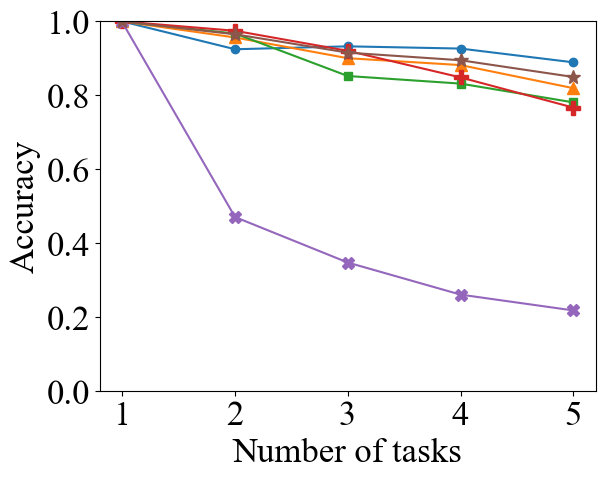

In [14]:
avg_data = list()
labels = list()

seed_range = [0, 1, 2, 3, 4]
epoch = 5
dataset = "MNIST"
FSW_metric = "EER"

# Modifier
target_metric = "accuracy" # EER, accuracy
y_range = [0, 1]
# y_range = [0, .6]
loc = None

metric = "no_metrics"
# 1
method = "iCaRL"
lr = 0.1
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 2
method = "WA"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 3
method = "GSS"
lr = 0.001
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 4
method = "OCS"
lr = 0.001
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 5
method = "FaIRL"
lr = 0.001
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)


# 6
method = "FSW"
lr = 0.001
tau = 10.0
alpha = 0.001
lmbd = 1.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, FSW_metric, target_metric))
labels.append(method)



draw_plot(avg_data, labels, dataset, ylabel=target_metric, y_range=y_range, loc=loc)

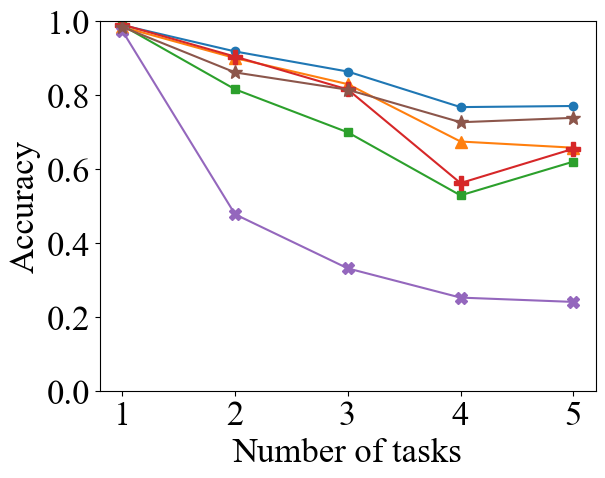

In [15]:
avg_data = list()
labels = list()

seed_range = [0, 1, 2, 3, 4]
epoch = 5
dataset = "FashionMNIST"
FSW_metric = "EER"

# Modifier
target_metric = "accuracy" # EER, accuracy
y_range = [0, 1]
# y_range = [0, .6]
loc = None


metric = "no_metrics"
# 1
method = "iCaRL"
lr = 0.1
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 2
method = "WA"
lr = 0.001
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 3
method = "GSS"
lr = 0.001
tau = 5.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 4
method = "OCS"
lr = 0.01
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 4
method = "FaIRL"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)


# 5
method = "FSW"
lr = 0.001
tau = 10.0
alpha = 0.001
lmbd = 0.1

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, FSW_metric, target_metric))
labels.append(method)



draw_plot(avg_data, labels, dataset, ylabel=target_metric, y_range=y_range, loc=loc)

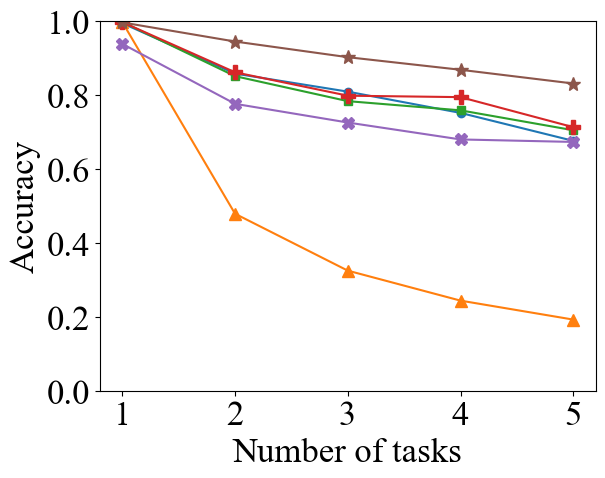

In [10]:
avg_data = list()
labels = list()

seed_range = [0, 1, 2, 3, 4]
epoch = 15
dataset = "BiasedMNIST"
FSW_metric = "EO"

# Modifier
target_metric = "accuracy" # EO, accuracy
y_range = [0, 1]
# y_range = [0, .7]
loc = None

metric = "no_metrics"
# 1
method = "iCaRL"
lr = 0.1
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 2
method = "WA"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 3
method = "GSS"
lr = 0.001
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 4
method = "OCS"
lr = 0.001
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 5
method = "FaIRL"
lr = 0.001
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)


# 6
method = "FSW"
lr = 0.001
tau = 5.0
alpha = 0.0005
lmbd = 0.5

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, FSW_metric, target_metric))
labels.append(method)



draw_plot(avg_data, labels, f"{dataset}({FSW_metric})", ylabel=target_metric, y_range=y_range, loc=loc)

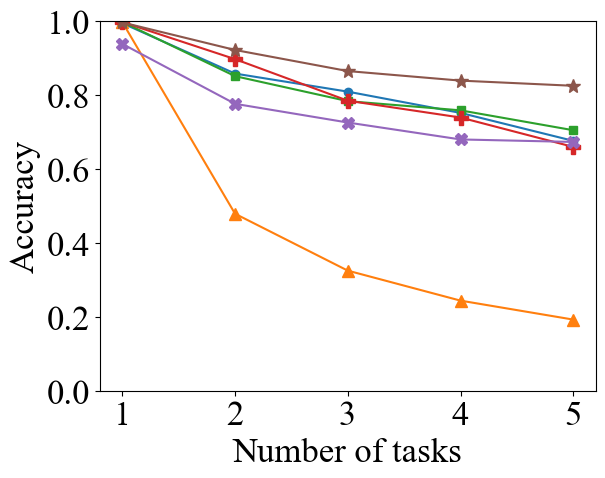

In [11]:
avg_data = list()
labels = list()

seed_range = [0, 1, 2, 3, 4]
epoch = 15
dataset = "BiasedMNIST"
FSW_metric = "DP"

# Modifier
target_metric = "accuracy" # DP, accuracy
y_range = [0, 1]
# y_range = [0, .08]
loc = None

metric = "no_metrics"
# 1
method = "iCaRL"
lr = 0.1
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 2
method = "WA"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 3
method = "GSS"
lr = 0.001
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 4
method = "OCS"
lr = 0.01
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 5
method = "FaIRL"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 6
method = "FSW"
lr = 0.001
tau = 10.0
alpha = 0.01
lmbd = 0.5

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, FSW_metric, target_metric))
labels.append(method)



draw_plot(avg_data, labels, f"{dataset}({FSW_metric})", ylabel=target_metric, y_range=y_range, loc=loc)

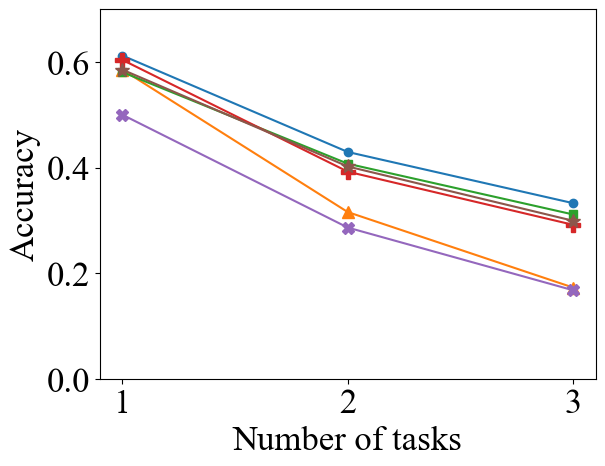

In [16]:
avg_data = list()
labels = list()

seed_range = [0, 1, 2, 3, 4]
epoch = 25
dataset = "Drug"
FSW_metric = "EO"

# Modifier
target_metric = "accuracy" # EO, accuracy
y_range = [0, .7]
# y_range = [0, .3]
loc = None

metric = "no_metrics"
# 1
method = "iCaRL"
lr = 0.1
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 2
method = "WA"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 3
method = "GSS"
lr = 0.001
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 4
method = "OCS"
lr = 0.01
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 5
method = "FaIRL"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 6
method = "FSW"
lr = 0.01
tau = 1.0
alpha = 0.01
lmbd = 0.1

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, FSW_metric, target_metric))
labels.append(method)



draw_plot(avg_data, labels, f"{dataset}({FSW_metric})", ylabel=target_metric, y_range=y_range, loc=loc)

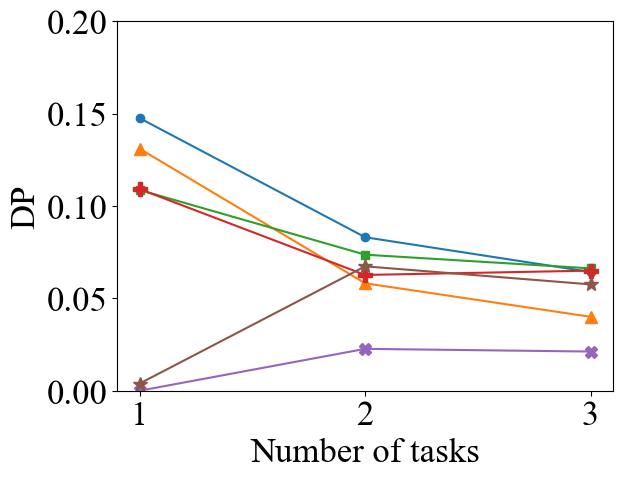

In [18]:
avg_data = list()
labels = list()

seed_range = [0, 1, 2, 3, 4]
epoch = 25
dataset = "Drug"
FSW_metric = "DP"

# Modifier
target_metric = "DP" # DP, accuracy
y_range = [0, .7]
y_range = [0, .2]
loc = None

metric = "no_metrics"
# 1
method = "iCaRL"
lr = 0.1
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 2
method = "WA"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 3
method = "GSS"
lr = 0.001
tau = 1.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 4
method = "OCS"
lr = 0.01
tau = 10.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 5
method = "FaIRL"
lr = 0.01
tau = 0.0
alpha = 0.0
lmbd = 0.0

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, metric, target_metric))
labels.append(method)

# 6
method = "FSW"
lr = 0.001
tau = 1.0
alpha = 0.002
lmbd = 0.1

avg_data.append(get_avg_data(seed_range, dataset, epoch, lr, tau, alpha, lmbd, method, FSW_metric, target_metric))
labels.append(method)



draw_plot(avg_data, labels, f"{dataset}({FSW_metric})", ylabel=target_metric, y_range=y_range, loc=loc)